# DEPENDENCIES

In [43]:
import pandas as pd
import numpy as np
import plotly.express as px
import matplotlib.pyplot as plt

import statsmodels.api as sm
from statsmodels.tsa.stattools import (
    adfuller,
    arma_order_select_ic,
    grangercausalitytests,
)
from statsmodels.tsa.arima.model import ARIMA

from statsmodels.tsa.vector_ar.vecm import (
    coint_johansen,
    select_order,
    select_coint_rank,
)
from statsmodels.stats.stattools import durbin_watson
from statsmodels.tsa.vector_ar.vecm import VECM

In [44]:
def plot_acf(df, col):
    fig, axes = plt.subplots(2, 2, figsize=(24, 12))
    ax1, ax2, ax3, ax4 = axes.flatten()

    sm.graphics.tsa.plot_acf(df[col].values.squeeze(), lags=20, ax=ax1)
    ax1.set_title(f"{col}: ACF of Original Data")

    sm.graphics.tsa.plot_acf(df[col].diff().dropna().values.squeeze(), lags=20, ax=ax2)
    ax2.set_title(f"{col}: ACF of Differenced Data")

    sm.graphics.tsa.plot_pacf(df[col].values.squeeze(), lags=20, ax=ax3)
    ax3.set_title(f"{col}: PACF of Original Data")
    sm.graphics.tsa.plot_pacf(df[col].diff().dropna().values.squeeze(), lags=20, ax=ax4)
    ax4.set_title(f"{col}: PACF of Differenced Data")

    plt.tight_layout()

    plt.show()

In [45]:
def coin_test(df, prod1, prod2):
    d1 = df[df["product"] == prod1].reset_index(drop=True)
    d2 = df[df["product"] == prod2].reset_index(drop=True)

    df = pd.merge(
        d1[["mid_price"]],
        d2[["mid_price"]],
        how="left",
        left_index=True,
        right_index=True,
        suffixes=(f"_{prod1}", f"_{prod2}"),
    )
    vecm_order = select_order(df, maxlags=10)
    print(vecm_order.summary())

    model = coint_johansen(endog=df, det_order=1, k_ar_diff=1)
    print("Eigen statistic:")
    print(model.eig)
    print("Critical values:")
    d = pd.DataFrame(model.cvt)
    d.rename(columns={0: "90%", 1: "95%", 2: "99%"}, inplace=True)
    print(d)
    print()
    print("Trace statistic:")
    print(pd.DataFrame(model.lr1))

    rank1 = select_coint_rank(df, det_order=1, k_ar_diff=1, method="trace", signif=0.01)
    print(rank1.summary())

    # Perform Granger causality tests
    max_lags = 5
    gc_results = grangercausalitytests(df, max_lags, verbose=True)

    vecm = VECM(
        df, k_ar_diff=1, coint_rank=1, deterministic="n"
    )  # Including a linear trend
    vecm_fit = vecm.fit()

    print(vecm_fit.summary())

    return vecm_fit

# READ DATA

In [46]:
dates = {
    # 1: [-2, -1, 0],
    2: [-1, 0, 1]
}

df = []
for round, days in dates.items():
    for day in days:
        data = pd.read_csv(
            f"C:/Users/edmun/OneDrive/Desktop/2025-IMC-Global-Trading-Challenge/prosperity3bt/resources/round{round}/prices_round_{round}_day_{day}.csv",
            sep=";",
        )
        data["round"] = round

        df.append(data)

data = pd.concat(df)

In [47]:
data.sort_values(by=["round", "day", "timestamp"], ascending=[True, True, True])

,day,timestamp,product,bid_price_1,bid_volume_1,bid_price_2,bid_volume_2,bid_price_3,bid_volume_3,ask_price_1,ask_volume_1,ask_price_2,ask_volume_2,ask_price_3,ask_volume_3,mid_price,profit_and_loss,round
0,-1,0,CROISSANTS,4304,112,NaN,NaN,NaN,NaN,4305,112,NaN,NaN,NaN,NaN,4304.5,0.0,2
1,-1,0,JAMS,6670,66,6669.0,137.0,NaN,NaN,6671,66,6672.0,137.0,NaN,NaN,6670.5,0.0,2
2,-1,0,SQUID_INK,2005,1,2002.0,31.0,NaN,NaN,2006,31,NaN,NaN,NaN,NaN,2005.5,0.0,2
3,-1,0,PICNIC_BASKET1,59284,20,59283.0,18.0,NaN,NaN,59294,2,59295.0,36.0,NaN,NaN,59289.0,0.0,2
4,-1,0,PICNIC_BASKET2,30606,20,30605.0,18.0,NaN,NaN,30612,20,30613.0,18.0,NaN,NaN,30609.0,0.0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
79995,1,999900,JAMS,6519,204,NaN,NaN,NaN,NaN,6521,204,NaN,NaN,NaN,NaN,6520.0,0.0,2
79996,1,999900,RAINFOREST_RESIN,9992,34,NaN,NaN,NaN,NaN,10008,34,NaN,NaN,NaN,NaN,10000.0,0.0,2
79997,1,999900,SQUID_INK,1880,20,NaN,NaN,NaN,NaN,1884,20,NaN,NaN,NaN,NaN,1882.0,0.0,2
79998,1,999900,PICNIC_BASKET1,58713,15,58712.0,21.0,NaN,NaN,58724,15,58725.0,21.0,NaN,NaN,58718.5,0.0,2


In [48]:
#################################### VOLUME METRICS ####################################

# Most Bid Volume - Identifies which bid price has the highest volume.
data["most_bid_volume_idx"] = data[
    ["bid_volume_1", "bid_volume_2", "bid_volume_3"]
].idxmax(axis=1)

# Most Ask Volume - Identifies which ask price has the highest volume.
data["most_ask_volume_idx"] = data[
    ["ask_volume_1", "ask_volume_2", "ask_volume_3"]
].idxmax(axis=1)

# Highest Bid Volume - The highest bid volume across the three bid price levels.
data["most_bid_volume"] = data[["bid_volume_1", "bid_volume_2", "bid_volume_3"]].max(
    axis=1
)

# Highest Ask Volume - The highest ask volume across the three ask price levels.
data["most_ask_volume"] = data[["ask_volume_1", "ask_volume_2", "ask_volume_3"]].max(
    axis=1
)

data["total_bid_volume"] = data[["bid_volume_1", "bid_volume_2", "bid_volume_3"]].sum(
    axis=1
)

data["total_ask_volume"] = data[["ask_volume_1", "ask_volume_2", "ask_volume_3"]].sum(
    axis=1
)

data["volume_ratio"] = data["total_bid_volume"] / data["total_ask_volume"]

data["orderbook_imb"] = (
    (data["total_bid_volume"] - data["total_ask_volume"])
    / (data["total_bid_volume"] + data["total_ask_volume"])
    * 100
)

data["price_impact_sell"] = data["total_bid_volume"] / (
    data["ask_price_1"] - data["bid_price_1"]
)

data["price_impact_buy"] = data["total_ask_volume"] / (
    data["ask_price_1"] - data["bid_price_1"]
)

data["rate_of_bid"] = data.groupby("product")["total_bid_volume"].diff()

data["rate_of_ask"] = data.groupby("product")["total_ask_volume"].diff()


#################################### PRICE METRICS ####################################
# Most Bid Price - Determines the bid price corresponding to the highest bid volume.
data["most_bid"] = np.where(
    data["most_bid_volume_idx"] == "bid_volume_1",
    data["bid_price_1"],
    np.where(
        data["most_bid_volume_idx"] == "bid_volume_2",
        data["bid_price_2"],
        np.where(
            data["most_bid_volume_idx"] == "bid_volume_3", data["bid_price_3"], np.nan
        ),
    ),
)

# Most Ask Price - Determines the ask price corresponding to the highest ask volume.
data["most_ask"] = np.where(
    data["most_ask_volume_idx"] == "ask_volume_1",
    data["ask_price_1"],
    np.where(
        data["most_ask_volume_idx"] == "ask_volume_2",
        data["ask_price_2"],
        np.where(
            data["most_ask_volume_idx"] == "ask_volume_3", data["ask_price_3"], np.nan
        ),
    ),
)

#################################### MID PRICE METRICS ####################################
# Most Mid Price - The mid price of the highest bid and ask prices.
data["most_mid"] = (data["most_ask"] + data["most_bid"]) / 2


#################################### VWAP METRICS ####################################
# Most Micro Price - A weighted average price using both bid and ask volumes.
data["most_micro"] = (
    data["most_ask"] * data["most_bid_volume"]
    + data["most_bid"] * data["most_ask_volume"]
) / (data["most_ask_volume"] + data["most_bid_volume"])

# Micro Price - A weighted average price based on the first bid and ask levels.
data["micro_price"] = (
    data["ask_price_1"] * data["bid_volume_1"]
    + data["bid_price_1"] * data["ask_volume_1"]
) / (data["ask_volume_1"] + data["bid_volume_1"])

# Ask VWAP - The volume-weighted average price for the ask side using the top 3 ask levels.
data["ask_vwap"] = (
    data["ask_price_1"] * data["ask_volume_1"]
    + data["ask_price_2"] * data["ask_volume_2"]
    + data["ask_price_3"] * data["ask_volume_3"]
) / (data["ask_volume_1"] + data["ask_volume_2"] + data["ask_volume_3"])

# Bid VWAP - The volume-weighted average price for the bid side using the top 3 bid levels.
data["bid_vwap"] = (
    data["bid_price_1"] * data["bid_volume_1"]
    + data["bid_price_2"] * data["bid_volume_2"]
    + data["bid_price_3"] * data["bid_volume_3"]
) / (data["bid_volume_1"] + data["bid_volume_2"] + data["bid_volume_3"])

# VWAP Mid - The VWAP midpoint between the ask and bid sides.
data["vwap_mid"] = (data["ask_vwap"] + data["bid_vwap"]) / 2


In [49]:
data.columns

Index(['day', 'timestamp', 'product', 'bid_price_1', 'bid_volume_1',
       'bid_price_2', 'bid_volume_2', 'bid_price_3', 'bid_volume_3',
       'ask_price_1', 'ask_volume_1', 'ask_price_2', 'ask_volume_2',
       'ask_price_3', 'ask_volume_3', 'mid_price', 'profit_and_loss', 'round',
       'most_bid_volume_idx', 'most_ask_volume_idx', 'most_bid_volume',
       'most_ask_volume', 'total_bid_volume', 'total_ask_volume',
       'volume_ratio', 'orderbook_imb', 'price_impact_sell',
       'price_impact_buy', 'rate_of_bid', 'rate_of_ask', 'most_bid',
       'most_ask', 'most_mid', 'most_micro', 'micro_price', 'ask_vwap',
       'bid_vwap', 'vwap_mid'],
      dtype='object')

In [50]:
prices = [
    "mid_price",
    "most_mid",
    "most_micro",
    "micro_price",
    "vwap_mid",
]

# Resin

In [51]:
resin = data[data["product"] == "RAINFOREST_RESIN"].fillna(0)

In [52]:
resin["bid_price_1"].value_counts().sort_index()

bid_price_1
9992     25090
9997      1934
10000      422
10001     1434
10002      837
10003      283
Name: count, dtype: int64

In [53]:
resin["ask_price_1"].value_counts().sort_index()

ask_price_1
9997       290
9998       840
9999      1361
10000      429
10003     1951
10008    25129
Name: count, dtype: int64

max sell @ bid = 9999 because min ask is 9998, sell at bid buy at ask

max buy @ ask = 10_001 because max bid = 10_002, buy at ask sell at bid

## KELP

In [54]:
kelp = data[data["product"] == "KELP"].fillna(0)

In [55]:
kelp

,day,timestamp,product,bid_price_1,bid_volume_1,bid_price_2,bid_volume_2,bid_price_3,bid_volume_3,ask_price_1,...,rate_of_bid,rate_of_ask,most_bid,most_ask,most_mid,most_micro,micro_price,ask_vwap,bid_vwap,vwap_mid
7,-1,0,KELP,2028,1,2026.0,2.0,2025.0,29.0,2029,...,0.0,0.0,2025.0,2029.0,2027.0,2026.933333,2028.031250,0.0,2025.156250,0.0
10,-1,100,KELP,2025,24,0.0,0.0,0.0,0.0,2028,...,-8.0,-7.0,2025.0,2029.0,2027.0,2027.086957,2027.769231,0.0,0.000000,0.0
18,-1,200,KELP,2025,22,0.0,0.0,0.0,0.0,2028,...,-2.0,-4.0,2025.0,2028.0,2026.5,2026.571429,2026.571429,0.0,0.000000,0.0
28,-1,300,KELP,2025,31,0.0,0.0,0.0,0.0,2028,...,9.0,11.0,2025.0,2029.0,2027.0,2027.066667,2027.818182,0.0,0.000000,0.0
39,-1,400,KELP,2025,27,0.0,0.0,0.0,0.0,2028,...,-4.0,-4.0,2025.0,2028.0,2026.5,2026.500000,2026.500000,0.0,0.000000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
79960,1,999500,KELP,2055,1,2054.0,1.0,2053.0,24.0,2057,...,-2.0,0.0,2053.0,2057.0,2055.0,2054.959184,2055.076923,0.0,2053.115385,0.0
79968,1,999600,KELP,2055,2,2053.0,24.0,0.0,0.0,2057,...,0.0,-1.0,2053.0,2057.0,2055.0,2055.000000,2055.153846,0.0,0.000000,0.0
79980,1,999700,KELP,2053,30,0.0,0.0,0.0,0.0,2054,...,4.0,7.0,2053.0,2057.0,2055.0,2055.000000,2053.967742,0.0,0.000000,0.0
79986,1,999800,KELP,2053,24,0.0,0.0,0.0,0.0,2055,...,-6.0,1.0,2053.0,2057.0,2055.0,2055.000000,2054.500000,0.0,0.000000,0.0


In [56]:
sq = data[data["product"] == "SQUID_INK"].reset_index(drop=True)
kelp = data[data["product"] == "KELP"].reset_index(drop=True)

mid_coin = pd.merge(
    sq[["mid_price"]],
    kelp[["mid_price"]],
    how="left",
    left_index=True,
    right_index=True,
    suffixes=("_sq", "_kelp"),
)

In [57]:
coin_test(data, "SQUID_INK", "KELP")

 VECM Order Selection (* highlights the minimums) 
       AIC         BIC         FPE         HQIC   
--------------------------------------------------
0       0.6835      0.6851       1.981      0.6840
1       0.4153      0.4181       1.515      0.4162
2       0.3338      0.3376       1.396      0.3350
3       0.2912      0.2962       1.338      0.2928
4       0.2728      0.2789       1.314      0.2748
5       0.2595      0.2667       1.296      0.2618
6       0.2533      0.2617       1.288      0.2560
7       0.2520      0.2614       1.287      0.2550
8       0.2500     0.2605*       1.284      0.2533
9       0.2490      0.2606       1.283      0.2527
10     0.2481*      0.2609      1.282*     0.2522*
--------------------------------------------------
Eigen statistic:
[0.00274653 0.00081553]
Critical values:
       90%      95%      99%
0  16.1619  18.3985  23.1485
1   2.7055   3.8415   6.6349

Trace statistic:
            0
0  106.977998
1   24.474297
Johansen cointegration test us

c:\Users\edmun\anaconda3\Lib\site-packages\statsmodels\tsa\stattools.py:1545: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(


Det. terms outside the coint. relation & lagged endog. parameters for equation mid_price_SQUID_INK
                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
L1.mid_price_SQUID_INK    -0.0956      0.006    -16.072      0.000      -0.107      -0.084
L1.mid_price_KELP         -0.2774      0.014    -19.181      0.000      -0.306      -0.249
Det. terms outside the coint. relation & lagged endog. parameters for equation mid_price_KELP
                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
L1.mid_price_SQUID_INK    -0.0012      0.002     -0.573      0.567      -0.006       0.003
L1.mid_price_KELP         -0.4784      0.005    -90.374      0.000      -0.489      -0.468
        Loading coefficients (alpha) for equation mid_price_SQUID_INK         


In [58]:
vecm = VECM(
    mid_coin, k_ar_diff=1, coint_rank=1, deterministic="n"
)  # Including a linear trend
vecm_fit = vecm.fit()

print(vecm_fit.summary())


Det. terms outside the coint. relation & lagged endog. parameters for equation mid_price_sq
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
L1.mid_price_sq      -0.0956      0.006    -16.072      0.000      -0.107      -0.084
L1.mid_price_kelp    -0.2774      0.014    -19.181      0.000      -0.306      -0.249
Det. terms outside the coint. relation & lagged endog. parameters for equation mid_price_kelp
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
L1.mid_price_sq      -0.0012      0.002     -0.573      0.567      -0.006       0.003
L1.mid_price_kelp    -0.4784      0.005    -90.374      0.000      -0.489      -0.468
            Loading coefficients (alpha) for equation mid_price_sq            
                 coef    std err          z    

In [59]:
out = durbin_watson(vecm_fit.resid)
for col, val in zip(mid_coin.columns, out):
    print(col, val)

mid_price_sq 2.0206869494630433
mid_price_kelp 2.2688981643384665


# SQUID INK

In [60]:
squid_ink = data[data["product"] == "SQUID_INK"]

In [61]:
squid_ink[squid_ink["day"] == 0]

,day,timestamp,product,bid_price_1,bid_volume_1,bid_price_2,bid_volume_2,bid_price_3,bid_volume_3,ask_price_1,...,rate_of_bid,rate_of_ask,most_bid,most_ask,most_mid,most_micro,micro_price,ask_vwap,bid_vwap,vwap_mid
5,0,0,SQUID_INK,1968,30,NaN,NaN,NaN,NaN,1971,...,-1.0,-7.0,1968.0,1971.0,1969.5,1969.500000,1969.500000,NaN,NaN,NaN
9,0,100,SQUID_INK,1969,4,1967.0,31.0,NaN,NaN,1971,...,5.0,1.0,1967.0,1971.0,1969.0,1969.000000,1969.228571,NaN,NaN,NaN
16,0,200,SQUID_INK,1966,1,1965.0,21.0,NaN,NaN,1969,...,-13.0,-9.0,1965.0,1969.0,1967.0,1966.953488,1966.130435,NaN,NaN,NaN
24,0,300,SQUID_INK,1965,25,NaN,NaN,NaN,NaN,1968,...,3.0,3.0,1965.0,1968.0,1966.5,1966.500000,1966.500000,NaN,NaN,NaN
37,0,400,SQUID_INK,1966,25,NaN,NaN,NaN,NaN,1968,...,0.0,6.0,1966.0,1969.0,1967.5,1967.500000,1967.612903,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
79961,0,999500,SQUID_INK,1830,28,NaN,NaN,NaN,NaN,1833,...,2.0,2.0,1830.0,1833.0,1831.5,1831.500000,1831.500000,NaN,NaN,NaN
79970,0,999600,SQUID_INK,1832,7,1831.0,29.0,NaN,NaN,1834,...,8.0,1.0,1831.0,1835.0,1833.0,1833.071429,1833.555556,NaN,NaN,NaN
79981,0,999700,SQUID_INK,1834,1,1832.0,26.0,NaN,NaN,1835,...,-9.0,-3.0,1832.0,1835.0,1833.5,1833.500000,1834.037037,NaN,NaN,NaN
79984,0,999800,SQUID_INK,1837,27,NaN,NaN,NaN,NaN,1839,...,0.0,2.0,1837.0,1840.0,1838.5,1838.500000,1838.928571,NaN,NaN,NaN


In [62]:
sq = data[data["product"] == "SQUID_INK"].reset_index(drop=True)
kelp = data[data["product"] == "KELP"].reset_index(drop=True)

mid_coin = pd.merge(
    sq[["mid_price"]],
    kelp[["mid_price"]],
    how="left",
    left_index=True,
    right_index=True,
    suffixes=("_sq", "_kelp"),
)

In [63]:
vecm_order = select_order(mid_coin, maxlags=10)
vecm_order.summary()

,AIC,BIC,FPE,HQIC
0,0.6835,0.6851,1.981,0.6840
1,0.4153,0.4181,1.515,0.4162
2,0.3338,0.3376,1.396,0.3350
3,0.2912,0.2962,1.338,0.2928
4,0.2728,0.2789,1.314,0.2748
5,0.2595,0.2667,1.296,0.2618
6,0.2533,0.2617,1.288,0.2560
7,0.2520,0.2614,1.287,0.2550
8,0.2500,0.2605*,1.284,0.2533
9,0.2490,0.2606,1.283,0.2527


In [64]:
model = coint_johansen(endog=mid_coin, det_order=1, k_ar_diff=1)
print("Eigen statistic:")
print(model.eig)
print("Critical values:")
d = pd.DataFrame(model.cvt)
d.rename(columns={0: "90%", 1: "95%", 2: "99%"}, inplace=True)
print(d)
print()
print("Trace statistic:")
print(pd.DataFrame(model.lr1))


Eigen statistic:
[0.00274653 0.00081553]
Critical values:
       90%      95%      99%
0  16.1619  18.3985  23.1485
1   2.7055   3.8415   6.6349

Trace statistic:
            0
0  106.977998
1   24.474297


In [65]:
rank1 = select_coint_rank(
    mid_coin, det_order=1, k_ar_diff=1, method="trace", signif=0.01
)
print(rank1.summary())


Johansen cointegration test using trace test statistic with 1% significance level
r_0 r_1 test statistic critical value
-------------------------------------
  0   2          107.0          23.15
  1   2          24.47          6.635
-------------------------------------


In [66]:
# Perform Granger causality tests
max_lags = 5
gc_results = grangercausalitytests(mid_coin, max_lags, verbose=True)


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=27.8273 , p=0.0000  , df_denom=29996, df_num=1
ssr based chi2 test:   chi2=27.8301 , p=0.0000  , df=1
likelihood ratio test: chi2=27.8172 , p=0.0000  , df=1
parameter F test:         F=27.8273 , p=0.0000  , df_denom=29996, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=191.0270, p=0.0000  , df_denom=29993, df_num=2
ssr based chi2 test:   chi2=382.1177, p=0.0000  , df=2
likelihood ratio test: chi2=379.7044, p=0.0000  , df=2
parameter F test:         F=191.0270, p=0.0000  , df_denom=29993, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=176.8742, p=0.0000  , df_denom=29990, df_num=3
ssr based chi2 test:   chi2=530.7463, p=0.0000  , df=3
likelihood ratio test: chi2=526.1056, p=0.0000  , df=3
parameter F test:         F=176.8742, p=0.0000  , df_denom=29990, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=152.0522

c:\Users\edmun\anaconda3\Lib\site-packages\statsmodels\tsa\stattools.py:1545: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(


In [67]:
vecm = VECM(
    mid_coin, k_ar_diff=1, coint_rank=1, deterministic="n"
)  # Including a linear trend
vecm_fit = vecm.fit()

print(vecm_fit.summary())


Det. terms outside the coint. relation & lagged endog. parameters for equation mid_price_sq
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
L1.mid_price_sq      -0.0956      0.006    -16.072      0.000      -0.107      -0.084
L1.mid_price_kelp    -0.2774      0.014    -19.181      0.000      -0.306      -0.249
Det. terms outside the coint. relation & lagged endog. parameters for equation mid_price_kelp
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
L1.mid_price_sq      -0.0012      0.002     -0.573      0.567      -0.006       0.003
L1.mid_price_kelp    -0.4784      0.005    -90.374      0.000      -0.489      -0.468
            Loading coefficients (alpha) for equation mid_price_sq            
                 coef    std err          z    

In [68]:
out = durbin_watson(vecm_fit.resid)
for col, val in zip(mid_coin.columns, out):
    print(col, ":", val)

mid_price_sq : 2.0206869494630433
mid_price_kelp : 2.2688981643384665


In [69]:
(
    vecm_fit.lin_trend_coint
    + vecm_fit.alpha @ (vecm_fit.beta.T @ mid_coin.iloc[-1].values)
    + vecm_fit.gamma @ (mid_coin.iloc[-1].values - vecm_fit.fittedvalues[-1])
)

array([[-0.36322511, -0.59610989]])

In [70]:
(
    mid_coin.iloc[-1].values
    + vecm_fit.alpha
    @ (vecm_fit.beta.T @ mid_coin.iloc[-2].values + vecm_fit.lin_trend_coint[0])
    + vecm_fit.gamma @ (mid_coin.iloc[-1].values - vecm_fit.fittedvalues[-1])
)

array([1881.63629518, 2054.40389867])

In [71]:
print(vecm_fit.alpha)
print()
print(vecm_fit.beta)
print()
print(vecm_fit.gamma)

[[-5.10651298e-04]
 [ 9.10917102e-06]]

[[ 1.        ]
 [-0.93940982]]

[[-0.09555001 -0.27741155]
 [-0.00124705 -0.47838647]]


In [72]:
vecm_fit.predict(steps=1)

array([[1881.74734849, 2054.52117185]])

# PICNIC BASKET 1 

In [73]:
cross = data[data["product"] == "CROISSANTS"]["mid_price"].reset_index(drop=True)
jams = data[data["product"] == "JAMS"]["mid_price"].reset_index(drop=True)
dj = data[data["product"] == "DJEMBES"]["mid_price"].reset_index(drop=True)

picnic1 = data[data["product"] == "PICNIC_BASKET1"].reset_index(drop=True)
picnic1["basket1"] = cross * 6 + jams * 3 + dj
picnic1.rename(columns={"mid_price": "mid_price1"}, inplace=True)
picnic1["prem_disc"] = picnic1["mid_price1"] - picnic1["basket1"]

picnic2 = data[data["product"] == "PICNIC_BASKET2"].reset_index(drop=True)
picnic2["basket2"] = cross * 4 + jams * 2
picnic2.rename(columns={"mid_price": "mid_price2"}, inplace=True)
picnic2["prem_disc"] = picnic2["mid_price2"] - picnic2["basket2"]

In [74]:
(picnic1["ask_price_1"] - picnic1["bid_price_1"]).value_counts()

9     12948
11     8459
10     4773
5      1415
4       883
6       604
12      436
1       432
2        40
7        10
Name: count, dtype: int64

In [75]:
(picnic2["ask_price_1"] - picnic2["bid_price_1"]).value_counts()

5    13099
6    12115
7     1448
3     1434
2     1123
1      405
4      376
Name: count, dtype: int64

In [76]:
picnic_mids = pd.merge(
    picnic1[["mid_price1", "basket1"]],
    picnic2[["mid_price2", "basket2"]],
    how="inner",
    left_index=True,
    right_index=True,
)

In [77]:
px.line(picnic1["prem_disc"])

In [78]:
px.line(picnic2["prem_disc"])

In [79]:
px.histogram(np.diff(picnic1["prem_disc"]))

<Axes: >

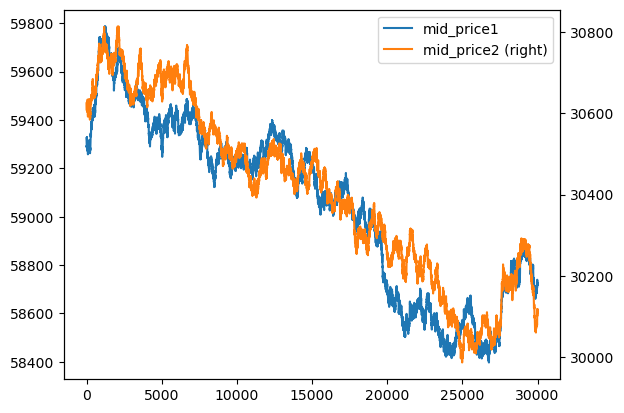

In [82]:
picnic_mids[["mid_price1", "mid_price2"]].plot(secondary_y="mid_price2")

In [83]:
forecast = np.zeros(len(picnic_mids))
x = picnic_mids[["mid_price1", "mid_price2"]].values
params = {
    "alpha": np.array([[-0.00019455], [0.00026457]]),
    "beta": np.array([[1.0, -1.94279816]]),
    "gamma": np.array(
        [[-0.03700845, -0.01196759], [-0.01018269, -0.0202882]],
    ),
}
p1 = np.zeros(len(picnic_mids))
p2 = np.zeros(len(picnic_mids))

for i in range(1, len(picnic_mids)):
    f1, f2 = params["alpha"] @ (params["beta"] @ x[i]) + params["gamma"] @ (
        x[i] - np.array(p1[i-1], p2[i-1])
    )
    p1[i] = f1 + x[i][0]
    p2[i] = f2+x[i][1]


In [84]:
picnic_coin_vecm = coin_test(data, "PICNIC_BASKET1", "PICNIC_BASKET2")

 VECM Order Selection (* highlights the minimums) 
       AIC         BIC         FPE         HQIC   
--------------------------------------------------
0        4.542       4.544       93.88       4.543
1        4.540      4.543*       93.71      4.541*
2        4.540       4.544       93.71       4.541
3        4.540       4.545       93.71       4.542
4       4.540*       4.546      93.70*       4.542
5        4.540       4.547       93.72       4.543
6        4.540       4.549       93.71       4.543
7        4.540       4.550       93.72       4.543
8        4.540       4.551       93.73       4.544
9        4.541       4.552       93.75       4.544
10       4.541       4.554       93.77       4.545
--------------------------------------------------
Eigen statistic:
[0.00057154 0.00024668]
Critical values:
       90%      95%      99%
0  16.1619  18.3985  23.1485
1   2.7055   3.8415   6.6349

Trace statistic:
           0
0  24.550918
1   7.400963
Johansen cointegration test using

c:\Users\edmun\anaconda3\Lib\site-packages\statsmodels\tsa\stattools.py:1545: FutureWarning:

verbose is deprecated since functions should not print results



Det. terms outside the coint. relation & lagged endog. parameters for equation mid_price_PICNIC_BASKET1
                                  coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
L1.mid_price_PICNIC_BASKET1    -0.0370      0.006     -5.864      0.000      -0.049      -0.025
L1.mid_price_PICNIC_BASKET2    -0.0120      0.010     -1.145      0.252      -0.032       0.009
Det. terms outside the coint. relation & lagged endog. parameters for equation mid_price_PICNIC_BASKET2
                                  coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
L1.mid_price_PICNIC_BASKET1    -0.0102      0.004     -2.670      0.008      -0.018      -0.003
L1.mid_price_PICNIC_BASKET2    -0.0203      0.006     -3.213      0.001      -0.033      -0.008
      Loading coefficien

In [85]:
print(picnic_coin_vecm.alpha)
print()
print(picnic_coin_vecm.beta)
print()
print(picnic_coin_vecm.gamma)

[[-0.00019455]
 [ 0.00026457]]

[[ 1.        ]
 [-1.94279816]]

[[-0.03700845 -0.01196759]
 [-0.01018269 -0.0202882 ]]


# CROISSANTS

In [86]:
c_vecm = coin_test(data, "CROISSANTS", "PICNIC_BASKET1")

 VECM Order Selection (* highlights the minimums) 
       AIC         BIC         FPE         HQIC   
--------------------------------------------------
0       0.8309      0.8326       2.295      0.8314
1       0.8019      0.8047       2.230      0.8028
2       0.8003     0.8042*       2.226     0.8015*
3      0.8001*      0.8051      2.226*      0.8017
4       0.8001      0.8062       2.226      0.8021
5       0.8004      0.8076       2.226      0.8027
6       0.8003      0.8086       2.226      0.8030
7       0.8003      0.8097       2.226      0.8033
8       0.8004      0.8109       2.226      0.8038
9       0.8005      0.8122       2.227      0.8043
10      0.8008      0.8135       2.227      0.8049
--------------------------------------------------
Eigen statistic:
[0.00048839 0.0002852 ]
Critical values:
       90%      95%      99%
0  16.1619  18.3985  23.1485
1   2.7055   3.8415   6.6349

Trace statistic:
           0
0  23.210922
1   8.556693
Johansen cointegration test using

c:\Users\edmun\anaconda3\Lib\site-packages\statsmodels\tsa\stattools.py:1545: FutureWarning:

verbose is deprecated since functions should not print results



Det. terms outside the coint. relation & lagged endog. parameters for equation mid_price_CROISSANTS
                                  coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
L1.mid_price_CROISSANTS        -0.1460      0.006    -24.013      0.000      -0.158      -0.134
L1.mid_price_PICNIC_BASKET1     0.0058      0.001     10.363      0.000       0.005       0.007
Det. terms outside the coint. relation & lagged endog. parameters for equation mid_price_PICNIC_BASKET1
                                  coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
L1.mid_price_CROISSANTS         0.4139      0.067      6.197      0.000       0.283       0.545
L1.mid_price_PICNIC_BASKET1    -0.0528      0.006     -8.610      0.000      -0.065      -0.041
        Loading coefficients

In [87]:
print(c_vecm.alpha)
print()
print(c_vecm.beta)
print()
print(c_vecm.gamma)

[[-0.00053585]
 [ 0.00605571]]

[[ 1.        ]
 [-0.07278752]]

[[-0.14600432  0.00577994]
 [ 0.41390133 -0.05275109]]


# JAMS

In [88]:
j_vecm = coin_test(data, "JAMS", "PICNIC_BASKET1")

 VECM Order Selection (* highlights the minimums) 
       AIC         BIC         FPE         HQIC   
--------------------------------------------------
0        1.477       1.479       4.381       1.478
1        1.468      1.471*       4.341      1.469*
2        1.468       1.472       4.342       1.469
3        1.468       1.473       4.341       1.470
4       1.468*       1.474      4.341*       1.470
5        1.468       1.475       4.341       1.471
6        1.468       1.477       4.342       1.471
7        1.468       1.478       4.343       1.472
8        1.469       1.479       4.344       1.472
9        1.469       1.480       4.344       1.472
10       1.469       1.482       4.345       1.473
--------------------------------------------------
Eigen statistic:
[0.00035198 0.00019049]
Critical values:
       90%      95%      99%
0  16.1619  18.3985  23.1485
1   2.7055   3.8415   6.6349

Trace statistic:
           0
0  16.275438
1   5.714899
Johansen cointegration test using

c:\Users\edmun\anaconda3\Lib\site-packages\statsmodels\tsa\stattools.py:1545: FutureWarning:

verbose is deprecated since functions should not print results



 Det. terms outside the coint. relation & lagged endog. parameters for equation mid_price_JAMS 
                                  coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
L1.mid_price_JAMS              -0.0667      0.006    -11.123      0.000      -0.078      -0.055
L1.mid_price_PICNIC_BASKET1     0.0048      0.001      6.502      0.000       0.003       0.006
Det. terms outside the coint. relation & lagged endog. parameters for equation mid_price_PICNIC_BASKET1
                                  coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
L1.mid_price_JAMS               0.2680      0.048      5.544      0.000       0.173       0.363
L1.mid_price_PICNIC_BASKET1    -0.0492      0.006     -8.195      0.000      -0.061      -0.037
           Loading coefficients 

In [89]:
print(j_vecm.alpha)
print()
print(j_vecm.beta)
print()
print(j_vecm.gamma)

[[-0.00020707]
 [ 0.00051619]]

[[ 1.        ]
 [-0.11137341]]

[[-0.06666785  0.00483818]
 [ 0.26798214 -0.04917357]]


# DJEMBES 

In [90]:
dj_vecm = coin_test(data, "DJEMBES", "PICNIC_BASKET1")

 VECM Order Selection (* highlights the minimums) 
       AIC         BIC         FPE         HQIC   
--------------------------------------------------
0        2.483       2.484       11.97       2.483
1       2.481*      2.484*      11.95*      2.482*
2        2.481       2.485       11.95       2.482
3        2.481       2.486       11.95       2.482
4        2.481       2.487       11.95       2.483
5        2.481       2.488       11.95       2.483
6        2.481       2.490       11.96       2.484
7        2.481       2.491       11.96       2.484
8        2.481       2.492       11.96       2.485
9        2.481       2.493       11.95       2.485
10       2.481       2.494       11.96       2.485
--------------------------------------------------
Eigen statistic:
[0.00033667 0.00021164]
Critical values:
       90%      95%      99%
0  16.1619  18.3985  23.1485
1   2.7055   3.8415   6.6349

Trace statistic:
           0
0  16.450471
1   6.349371
Johansen cointegration test using

c:\Users\edmun\anaconda3\Lib\site-packages\statsmodels\tsa\stattools.py:1545: FutureWarning:

verbose is deprecated since functions should not print results



Det. terms outside the coint. relation & lagged endog. parameters for equation mid_price_DJEMBES
                                  coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
L1.mid_price_DJEMBES            0.0139      0.006      2.360      0.018       0.002       0.025
L1.mid_price_PICNIC_BASKET1     0.0022      0.001      1.900      0.057   -7.06e-05       0.005
Det. terms outside the coint. relation & lagged endog. parameters for equation mid_price_PICNIC_BASKET1
                                  coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
L1.mid_price_DJEMBES            0.0033      0.029      0.114      0.909      -0.054       0.061
L1.mid_price_PICNIC_BASKET1    -0.0401      0.006     -6.825      0.000      -0.052      -0.029
         Loading coefficients (

In [91]:
print(dj_vecm.alpha)
print()
print(dj_vecm.beta)
print()
print(dj_vecm.gamma)

[[-8.64219383e-05]
 [ 5.49907373e-04]]

[[ 1.       ]
 [-0.2278196]]

[[ 0.01386504  0.00224211]
 [ 0.00333236 -0.04007833]]
